In [26]:
%matplotlib inline
import functools
import itertools
import multiprocess as mp

import pandas as pd
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

import edgedroid.data as e_data
import edgedroid.util as util
from edgedroid.execution_times import *
from mpl_toolkits import mplot3d

raw_data_params = e_data.load_default_exec_time_data()
data = preprocess_data(*raw_data_params)
raw_data, *_ = raw_data_params
data

,run_id,seq,neuroticism,impairment,next_exec_time,transition,duration
0,134146,1,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",2.956,NoTransition,"[0.0, 5.0)"
1,134146,2,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",5.443,NoTransition,"[0.0, 5.0)"
2,134146,3,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",5.206,NoTransition,"[0.0, 5.0)"
3,134146,4,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",4.783,NoTransition,"[0.0, 5.0)"
4,134146,5,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",2.760,NoTransition,"[5.0, 10.0)"
...,...,...,...,...,...,...,...
6715,137353,164,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",4.722,Higher2Lower,"[5.0, 10.0)"
6716,137353,165,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",3.475,Higher2Lower,"[5.0, 10.0)"
6717,137353,166,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",2.296,Higher2Lower,"[10.0, inf)"
6718,137353,167,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",4.608,Higher2Lower,"[10.0, inf)"


In [2]:
raw_data

,run_id,seq,exec_time,delay,neuroticism
0,134146,1,4.433,0.0,0.375
1,134146,2,2.956,0.0,0.375
2,134146,3,5.443,0.0,0.375
3,134146,4,5.206,0.0,0.375
4,134146,5,4.783,0.0,0.375
...,...,...,...,...,...
6715,137353,164,6.501,0.0,0.625
6716,137353,165,4.722,0.0,0.625
6717,137353,166,3.475,0.0,0.625
6718,137353,167,2.296,0.0,0.625


In [3]:
# generate data for model

num_traces = 100
run_ids = raw_data.run_id.unique()
run_len = len(raw_data[raw_data.run_id == np.random.choice(run_ids)].index)

results = {}

with mp.Pool() as pool:
    for model_cls in (TheoreticalExecutionTimeModel, EmpiricalExecutionTimeModel):
        # diff_vals = np.empty((len(run_ids), num_traces, run_len))

        # diff_vals = pd.DataFrame(
        #     index=pd.MultiIndex.from_product((run_ids, range(num_traces), range(run_len))),
        #     columns=['diff']
        # )
        dfs = deque()

        model_name = model_cls.__name__

        for participant in tqdm(run_ids, desc=model_name, leave=True):
            # calculate average model deviation wrt to real data
            # by generating num_traces for each experimental run,
            # and then averaging the difference per step

            raw_delays = raw_data[raw_data.run_id == participant].delay
            neuro = raw_data[raw_data.run_id == participant].neuroticism.values[0]
            raw_exec_times = raw_data[raw_data.run_id == participant].exec_time.to_numpy()

            model = model_cls(data=data, neuroticism=neuro)

            for j, trace in enumerate(
                pool.imap(
                    lambda t: util.gen_model_trace(delays=t[0], model=t[1](data=t[2], neuroticism=t[3])),
                    zip(
                        itertools.repeat(raw_delays, num_traces),
                        itertools.repeat(model_cls),
                        itertools.repeat(data),
                        itertools.repeat(neuro)
                    )
                )
            ):
                # for j, trace in enumerate(pool.starmap(
                #         util.gen_model_trace,
                #         zip(itertools.repeat(raw_delays, num_traces),
                #             itertools.repeat(model))
                # )):
                # trace["raw_exec_time"] = np.nan
                trace["raw_exec_time"] = np.concatenate((raw_exec_times, [np.nan]))
                trace["run_id"] = participant
                trace["exec_time_diff"] = (trace["exec_time"] - trace["raw_exec_time"]) / trace["raw_exec_time"]
                trace.index = trace.index.set_names(["step_index"])
                dfs.append(trace.reset_index())

                # trace = (trace[:-1] - raw_exec_times) / raw_exec_times
                # diff_vals.loc[pd.IndexSlice[participant, j, :]] = np.atleast_2d(trace).T

        results[model_name] = pd.concat(dfs, ignore_index=True)
        results[model_name]["model"] = model_name

results = pd.concat(results.values(), ignore_index=True)

TheoreticalExecutionTimeModel:   0%|          | 0/40 [00:00<?, ?it/s]

EmpiricalExecutionTimeModel:   0%|          | 0/40 [00:00<?, ?it/s]

In [4]:
results

,step_index,model neuroticism,model neuroticism (binned),latest impairment,latest transition,current duration,current duration (binned),exec_time,delay,raw_exec_time,run_id,exec_time_diff,model
0,0,0.375,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",NoTransition,0,"[0.0, 5.0)",5.320193,NaN,4.433,134146,0.200134,TheoreticalExecutionTimeModel
1,1,0.375,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",NoTransition,1,"[0.0, 5.0)",3.364583,0.0,2.956,134146,0.138222,TheoreticalExecutionTimeModel
2,2,0.375,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",NoTransition,2,"[0.0, 5.0)",10.443031,0.0,5.443,134146,0.918617,TheoreticalExecutionTimeModel
3,3,0.375,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",NoTransition,3,"[0.0, 5.0)",8.815447,0.0,5.206,134146,0.693324,TheoreticalExecutionTimeModel
4,4,0.375,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",NoTransition,4,"[0.0, 5.0)",6.073747,0.0,4.783,134146,0.269861,TheoreticalExecutionTimeModel
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1351995,164,0.625,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",Higher2Lower,8,"[5.0, 10.0)",4.027000,0.0,4.722,137353,-0.147183,EmpiricalExecutionTimeModel
1351996,165,0.625,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",Higher2Lower,9,"[5.0, 10.0)",3.511000,0.0,3.475,137353,0.010360,EmpiricalExecutionTimeModel
1351997,166,0.625,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",Higher2Lower,10,"[10.0, inf)",4.429000,0.0,2.296,137353,0.929007,EmpiricalExecutionTimeModel
1351998,167,0.625,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",Higher2Lower,11,"[10.0, inf)",2.195000,0.0,4.608,137353,-0.523655,EmpiricalExecutionTimeModel


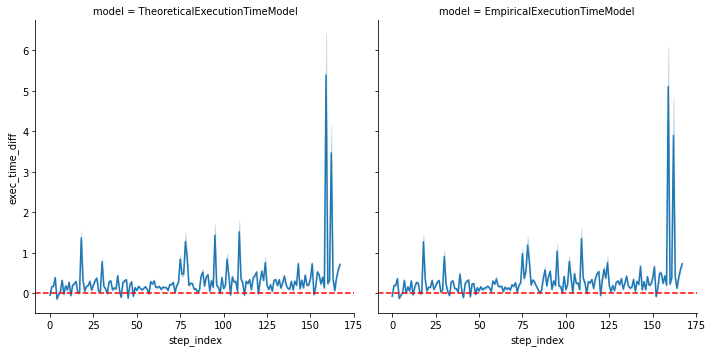

In [5]:
fg = sns.relplot(
    x='step_index',
    y='exec_time_diff',
    kind='line',
    data=results,
    col='model'
)
fg.refline(y=0, color='red')
plt.show()

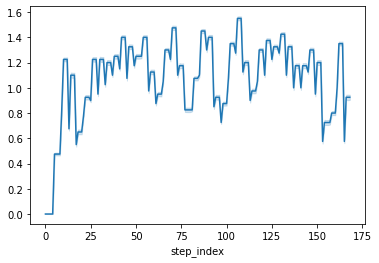

In [6]:
sns.lineplot(
    x='step_index',
    y=results['current duration (binned)'].astype('category').cat.codes,
    data=results
)
plt.show()

In [7]:
results.groupby([
    "latest impairment",
    "latest transition",
    "current duration (binned)",
])["exec_time_diff"].describe().sort_values(by=["mean"])


count  \
latest impairment latest transition current duration (binned)             
[-inf, 1.0)       NoTransition      [0.0, 5.0)                  23200.0   
[1.0, 2.0)        Lower2Higher      [10.0, inf)                 48400.0   
                  Higher2Lower      [5.0, 10.0)                 58000.0   
[-inf, 1.0)       NoTransition      [5.0, 10.0)                 15400.0   
[1.0, 2.0)        Lower2Higher      [5.0, 10.0)                 22000.0   
                  Higher2Lower      [0.0, 5.0)                  74600.0   
[-inf, 1.0)       Higher2Lower      [5.0, 10.0)                134800.0   
                                    [10.0, inf)                 89800.0   
                  NoTransition      [10.0, inf)                  7800.0   
[1.0, 2.0)        Lower2Higher      [0.0, 5.0)                  20800.0   
                  Higher2Lower      [10.0, inf)                159600.0   
[2.0, inf)        Lower2Higher      [0.0, 5.0)                 189200.0   
                                    [5.0, 10.0)                152000.0   
[-inf, 1.0)       Higher2Lower      [0.0, 5.0)                 117000.0   
[2.0, inf)        Lower2Higher      [10.0, inf)                231400.0   

                                                                   mean  \
latest impairment latest transition current duration (binned)             
[-inf, 1.0)       NoTransition      [0.0, 5.0)                 0.063811   
[1.0, 2.0)        Lower2Higher      [10.0, inf)                0.153550   
                  Higher2Lower      [5.0, 10.0)                0.175108   
[-inf, 1.0)       NoTransition      [5.0, 10.0)                0.181452   
[1.0, 2.0)        Lower2Higher      [5.0, 10.0)                0.186464   
                  Higher2Lower      [0.0, 5.0)                 0.191251   
[-inf, 1.0)       Higher2Lower      [5.0, 10.0)                0.195387   
                                    [10.0, inf)                0.202390   
                  NoTransition      [10.0, inf)                0.207841   
[1.0, 2.0)        Lower2Higher      [0.0, 5.0)                 0.209950   
                  Higher2Lower      [10.0, inf)                0.214325   
[2.0, inf)        Lower2Higher      [0.0, 5.0)                 0.310027   
                                    [5.0, 10.0)                0.322785   
[-inf, 1.0)       Higher2Lower      [0.0, 5.0)                 0.488302   
[2.0, inf)        Lower2Higher      [10.0, inf)                0.545489   

                                                                    std  \
latest impairment latest transition current duration (binned)             
[-inf, 1.0)       NoTransition      [0.0, 5.0)                 0.556663   
[1.0, 2.0)        Lower2Higher      [10.0, inf)                0.673301   
                  Higher2Lower      [5.0, 10.0)                0.783768   
[-inf, 1.0)       NoTransition      [5.0, 10.0)                0.773481   
[1.0, 2.0)        Lower2Higher      [5.0, 10.0)                0.768641   
                  Higher2Lower      [0.0, 5.0)                 0.783505   
[-inf, 1.0)       Higher2Lower      [5.0, 10.0)                0.807880   
                                    [10.0, inf)                0.807846   
                  NoTransition      [10.0, inf)                0.799739   
[1.0, 2.0)        Lower2Higher      [0.0, 5.0)                 0.820818   
                  Higher2Lower      [10.0, inf)                0.892098   
[2.0, inf)        Lower2Higher      [0.0, 5.0)                 1.840122   
                                    [5.0, 10.0)                2.046155   
[-inf, 1.0)       Higher2Lower      [0.0, 5.0)                 8.680743   
[2.0, inf)        Lower2Higher      [10.0, inf)                5.304341   

                                                                    min  \
latest impairment latest transition current duration (binned)             
[-inf, 1.0)       NoTransition      [0.0, 5.0)                -0.860693   
[1.0, 2.0)   

In [8]:
results[results['exec_time_diff'] >= 200]


,step_index,model neuroticism,model neuroticism (binned),latest impairment,latest transition,current duration,current duration (binned),exec_time,delay,raw_exec_time,run_id,exec_time_diff,model
68435,159,0.750,"[0.6666666666666666, inf)","[-inf, 1.0)",Higher2Lower,3,"[0.0, 5.0)",7.503613,0.000,0.032,134623,233.487909,TheoreticalExecutionTimeModel
68604,159,0.750,"[0.6666666666666666, inf)","[-inf, 1.0)",Higher2Lower,3,"[0.0, 5.0)",8.435273,0.000,0.032,134623,262.602291,TheoreticalExecutionTimeModel
69280,159,0.750,"[0.6666666666666666, inf)","[-inf, 1.0)",Higher2Lower,3,"[0.0, 5.0)",6.997274,0.000,0.032,134623,217.664818,TheoreticalExecutionTimeModel
69618,159,0.750,"[0.6666666666666666, inf)","[-inf, 1.0)",Higher2Lower,3,"[0.0, 5.0)",8.435273,0.000,0.032,134623,262.602291,TheoreticalExecutionTimeModel
69787,159,0.750,"[0.6666666666666666, inf)","[-inf, 1.0)",Higher2Lower,3,"[0.0, 5.0)",6.997274,0.000,0.032,134623,217.664818,TheoreticalExecutionTimeModel
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1196175,162,0.781,"[0.6666666666666666, inf)","[2.0, inf)",Lower2Higher,10,"[10.0, inf)",19.611000,2.175,0.049,136858,399.224490,EmpiricalExecutionTimeModel
1196344,162,0.781,"[0.6666666666666666, inf)","[2.0, inf)",Lower2Higher,10,"[10.0, inf)",10.760000,2.175,0.049,136858,218.591837,EmpiricalExecutionTimeModel
1198203,162,0.781,"[0.6666666666666666, inf)","[2.0, inf)",Lower2Higher,10,"[10.0, inf)",32.444000,2.175,0.049,136858,661.122449,EmpiricalExecutionTimeModel
1198372,162,0.781,"[0.6666666666666666, inf)","[2.0, inf)",Lower2Higher,10,"[10.0, inf)",14.542000,2.175,0.049,136858,295.775510,EmpiricalExecutionTimeModel


In [9]:
results.groupby('run_id')['exec_time_diff'].describe().sort_values(by='max', ascending=False)

,count,mean,std,min,25%,50%,75%,max
run_id,,,,,,,,
136858,33600.0,1.766411,12.729174,-1.105256,-0.208524,0.221529,0.870357,661.122449
134623,33600.0,1.582764,16.241144,-1.064013,-0.312051,0.090496,0.632721,660.656250
135343,33600.0,0.838318,3.841334,-1.166110,-0.263609,0.168705,0.903694,186.514286
136144,33600.0,0.710498,4.586663,-1.058985,-0.324086,0.064308,0.648465,185.252336
137299,33600.0,0.605106,2.608337,-1.226224,-0.257184,0.136830,0.764584,107.338542
135955,33600.0,0.468396,1.397733,-2.060344,-0.264257,0.128899,0.775868,63.915309
135301,33600.0,0.308576,1.241321,-1.147977,-0.334777,0.013493,0.578772,58.290155
136930,33600.0,0.444733,1.744882,-1.101355,-0.282497,0.052596,0.575947,55.456091
135385,33600.0,0.572605,1.987234,-0.997284,-0.264204,0.131089,0.802687,50.967213


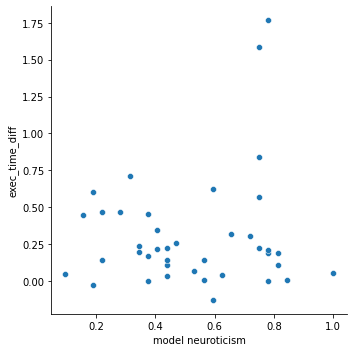

In [14]:
sns.relplot(
    kind='scatter',
    x='model neuroticism',
    y='exec_time_diff',
    data=results.groupby('run_id')[['model neuroticism', 'exec_time_diff']].mean()
)
plt.show()

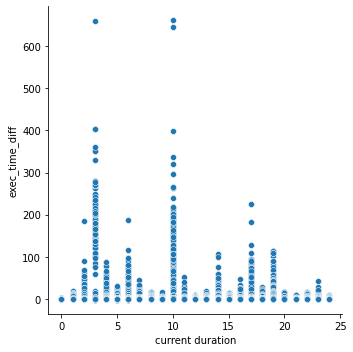

In [17]:
fg = sns.relplot(
    kind='scatter',
    x='current duration',
    y='exec_time_diff',
    data=results
)
# fg.set(yscale='log')
plt.show()

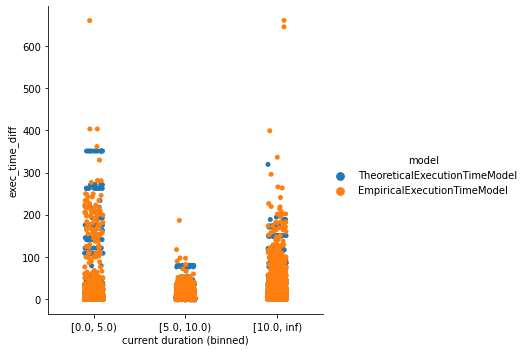

In [22]:
fg = sns.catplot(
    # kind='box',
    x='current duration (binned)',
    y='exec_time_diff',
    data=results,
    hue='model',
)
plt.show()

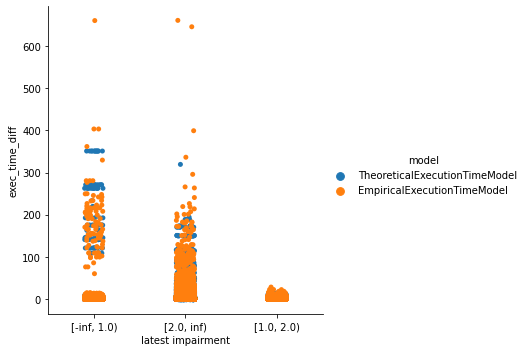

In [24]:
fg = sns.catplot(
    # kind='box',
    x='latest impairment',
    y='exec_time_diff',
    data=results,
    hue='model',
)
plt.show()

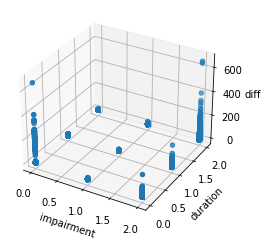

In [31]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter3D(
    results['latest impairment'].astype('category').cat.codes,
    results['current duration (binned)'].astype('category').cat.codes,
    results['exec_time_diff']
)
ax.set_xlabel('impairment')
ax.set_ylabel('duration')
ax.set_zlabel('diff')

plt.show()

In [32]:
results.corr()

,step_index,model neuroticism,current duration,exec_time,delay,raw_exec_time,run_id,exec_time_diff
step_index,1.000000e+00,3.423592e-15,0.112435,-0.013363,-7.390334e-03,-0.079614,-1.059868e-14,0.037641
model neuroticism,3.423592e-15,1.000000e+00,0.000583,0.038134,-2.133556e-15,0.049796,-2.340620e-01,0.013147
current duration,1.124351e-01,5.826580e-04,1.000000,-0.043820,1.283764e-01,-0.051259,-2.741541e-03,0.004758
exec_time,-1.336312e-02,3.813434e-02,-0.043820,1.000000,1.348270e-01,0.037178,-1.686001e-02,0.189100
delay,-7.390334e-03,-2.133556e-15,0.128376,0.134827,1.000000e+00,0.151083,1.102349e-14,0.012864
raw_exec_time,-7.961419e-02,4.979646e-02,-0.051259,0.037178,1.510834e-01,1.000000,1.805447e-02,-0.162923
run_id,-1.059868e-14,-2.340620e-01,-0.002742,-0.016860,1.102349e-14,0.018054,1.000000e+00,-0.002737
exec_time_diff,3.764058e-02,1.314707e-02,0.004758,0.189100,1.286422e-02,-0.162923,-2.736777e-03,1.000000
